# Introduction to atomman: Volterra dislocation solutions

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction<a id='section1'></a>

This Notebook outlines the classes and methods in atomman for obtaining elastic solutions for perfectly straight dislocations, i.e. Volterra dislocation solutions. The Volterra dislocation solutions are useful for both studying idealized dislocation properties and for inserting dislocations into atomic configurations.

- [Section #2](#section2) details the theory used to obtain the dislocation solutions.
- [Section #3](#section3) describes the VolterraDislocation classes that provide the elastic dislocation solutions and the various properties that can be obtained from them.

NOTE: For those wishing to generate atomic configurations containing dislocations, check out the documentation for the Dislocation class.  It provides user-friendly methods for constructing some standard dislocation configurations.  


In [1]:
# Standard Python libraries
import os
import datetime

# http://www.numpy.org/
import numpy as np

from scipy.stats import linregress

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today()) 

atomman version = 1.4.11
Notebook executed on 2024-04-29


## 2. Theory<a id='section2'></a>

Dislocation theory is based on computing and using elasticity solutions of dislocations to define what they look like and how they interact with the surrounding material. The Volterra dislocation model assumes that the discontinuity in the crystal due to the dislocation exists as a line singularity. While this assumption does not hold true in real materials, the Volterra solution still provides a decent guess for the long-range stress and strain fields of compact dislocation cores. It also provides a useful starting point for developing more complicated dislocation solutions, and can provide good initial guesses for constructing atomic dislocation configurations.

Solutions of straight dislocations are always defined relative to three orthogonal unit vectors $\hat{m}$, $\hat{n}$, and $\hat{\xi}$

- $\hat{m}$ is the direction in the slip plane perpendicular to the dislocation's line direction.
- $\hat{n}$ is the normal of the dislocation's slip plane.
- $\hat{\xi}$ is parallel to the dislocation's line direction.

Based on these three vectors, we can define a Cartesian coordinate system for the dislocation solution with positions, $x_i$, given by

$$ x_i = x_1 \hat{m} + x_2 \hat{n} + x_3 \hat{\xi} $$

For straight dislocations, the elasticity solutions are independent of the $x_3$ direction and therefore only depend on $x_1$ and $x_2$.

### 2.1. Isotropic solution

For isotropic materials, the elastic solution for a Volterra dislocation can be given as analytical equations.  Variations of the analytical solutions can be found in every textbook on dislocation theory.  The particular equations used in atomman match those found in Elementary Dislocation Theory by Weertman and Weertman except with flipped signs.  This choice provides the best correspondence with the anisotropic solution described below.

Isotropic elastic constants can be represented using only two independent terms. The two isotropic elastic constants typically used in the dislocation solutions are the shear modulus, $\mu$, and the Poisson's ratio, $\nu$.

The isotropic displacements, $u_i$, for a dislocation centered at $x_1 = x_2 = 0$ are

$$ u_1 = \frac{b_1}{2 \pi} \left[ \theta + \frac{x_1x_2}{2 (1 - \nu) (x_1^2 + x_2^2)} \right]$$

$$ u_2 = \frac{b_1}{2 \pi} \left[ -\frac{1 - 2 \nu} {4 (1 - \nu)} \ln(x_1^2 + x_2^2)
                           + \frac{y^2} {2 (1 - \nu) (x^2 + y^2)} \right]$$

$$ u_3 = \frac{b_3}{2 \pi} \theta.$$

Here (and below), $\theta$ is the radial angle coordinate

$$\theta=\tan^{-1} (x_2/x_1),$$

which is taken to range from $-\pi$ to $\pi$.

The isotropic stress, $\sigma_{ij}$, is given by the equations

$$ \sigma_{11} = -\frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_2 (3 x_1^2 + x_2^2)} { (x_1^2 + x_2^2)^2}$$

$$ \sigma_{22} = \frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_2 (x_1^2 - x_2^2)} { (x_1^2 + x_2^2)^2}$$

$$ \sigma_{33} = \nu(\sigma_{11} + \sigma_{22})$$

$$ \sigma_{12} = \frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_1(x_1^2 - x_2^2)) }{ (x_1^2 + x_2^2)^2}$$

$$ \sigma_{13} =-\frac{\mu b_3}{2 \pi} \frac{x_2}{(x_1^2 + x_2^2)} $$

$$ \sigma_{23} = \frac{\mu b_3}{2 \pi} \frac{x_1}{(x_1^2 + x_2^2)} $$

Analytical solutions for the isotropic strain can be derived from $\epsilon_{ij} = S_{ijkl} \sigma_{kl}$

$$ Q = \frac{b_1}{4 \pi (1 - \nu^2)} \frac{x_2}{(x_1^2 + x_2^2)^2}$$

$$ \epsilon_{11} = Q \left[ x_1^2 \left( -3 - \nu + 2 \nu^2 \right) + x_2^2 \left( -1 + \nu + 2 \nu^2 \right) \right] $$
$$ \epsilon_{22} = Q \left[ x_1^2 \left( 1 + 3 \nu + 2 \nu^2 \right) + x_2^2 \left( -1 + \nu + 2 \nu^2 \right) \right] $$


$$ \epsilon_{33} = 0.0 $$

$$ \epsilon_{12} = \frac{b_1}{4 \pi (1 - \nu)} \frac{ x_1 (x_1^2 - x_2^2) }{(x_1^2 + x_2^2)^2} $$

$$ \epsilon_{13} = -\frac{b_3}{4 \pi} \frac{x_2} {(x_1^2 + x_2^2)} $$

$$ \epsilon_{23} =  \frac{b_3}{4 \pi} \frac{x_1} {(x_1^2 + x_2^2)} $$

The energy coefficient tensor, $K_{ij}$, depends on the elastic constants.  Only normal components are non-zero for the isotropic case

$$K_{11}^{iso} = K_{22}^{iso} = K_{edge}^{iso} = \frac{\mu}{1 - \nu}$$
$$K_{33}^{iso} = K_{screw}^{iso} = \mu.$$

__Caution__: $K_{ij}$ may be defined slightly differently in other works depending on if they contain multiplicative factors.  If you are comparing atomman's values to other works, be sure to double check how $K_{ij}$ and the self-energy equations below are defined.

The dislocation's self-energy is the energy per unit length within a ring region around the dislocation line.  It depends on $K_{ij}$ and $b_i$

$$\frac{W}{l} = \frac{b_i K_{ij} b_j}{4 \pi} \ln{ \left( \frac{R}{r_0} \right)}.$$

The energy coefficient tensor can also be reduced down to a single coefficient, $K$, by accounting for the dislocation character

$$ K = \frac{b_i K_{ij} b_j} {b_k b_k}.$$

With this, the self-energy expression becomes

$$\frac{W}{l} = \frac{K b^2}{4 \pi} \ln{ \left( \frac{R}{r_0} \right)}, $$

Alternatively, everything in the self-energy expression outside the ln term can be grouped together as the pre-ln factor, $a$

$$\frac{W}{l} = a \ln{ \left( \frac{R}{r_0} \right)}. $$

### 2.2. Anisotropic solution

The elasticity solution for Volterra dislocations in anisotropic materials was first introduced by [Eshelby](https://doi.org/10.1016/0001-6160(53)90099-6). Starting with the fundamental equations of elasticity

$$ \sigma_{ij} = C_{ijkl} \epsilon_{kl} $$

$$ \epsilon_{ij} = \frac{1}{2} \left(\frac{\partial u_i}{\partial x_j} + \frac{\partial u_j}{\partial x_i}\right) $$

$$ \frac{\partial \sigma_{ij}}{\partial x_j} = 0 $$

Combining these and taking the solution to be independent of $x_3$ generates the partial differential equation

$$ C_{ijkl} \frac{ \partial^2 u_k}{\partial x_j \partial x_l} = 0 $$

Solutions of the partial differential equation are of the form

$$ u_k = A_k f(x_1 + p x_2) $$

Values of $A_k$ and $p$ can be found by solving

$$ \left[C_{i1k1} + \left(C_{i1k2} + C_{i2k1} \right) p + C_{i2k2} p^2 \right] A_k = 0 $$

The determinate expression is a sixth-order polynomial expression resulting in six complex roots, $p_\alpha$ with $\alpha$ ranging 1 to 6. There is also one $A_{k \alpha}$ corresponding to each root.

Later, [Stroh](https://doi.org/10.1080/14786435808565804) introduced a method for easily solving for the six roots.  Another vector, $L_i$ is defined for each $\alpha$ root as

$$ L_{i \alpha} = \left(C_{i2k1} + p_{\alpha} C_{i2k2} \right) A_{k \alpha} $$

and a normalization factor, $k_{\alpha}$, is introduced as

$$ k_{\alpha} = \frac{1}{2 A_{j \alpha} L_{j \alpha}} $$

Stroh's method then expresses everything as an eigenvector problem in which the eigenvalues give $p_{\alpha}$ and the eigenvectors give $A_{i \alpha}$ and $L_{i \alpha}$.  Properties of the dislocation can then be computed using these solution parameters

$$ u_i = \frac{1}{2 \pi i} \sum_{\alpha}  \pm k_{\alpha} A_{i \alpha} (L_{l \alpha} b_l) \ln{\eta_{\alpha}}$$

$$ \sigma_{ij} = \frac{1}{2 \pi i} \sum_{\alpha}  \pm k_{\alpha} C_{ijkl}[m_l + p_{\alpha} n_l] A_{k \alpha} (L_{m \alpha} b_m) \frac{1}{\eta_{\alpha}} $$

$$ \epsilon_{ij} = \frac{1}{4 \pi i} \sum_{\alpha} \pm k_{\alpha} \left(
[m_i + p_{\alpha} n_i] A_{j \alpha} + [m_j + p_{\alpha} n_j] A_{i \alpha} \right) \left( L_{m\alpha} b_m\right)\frac{1}{\eta_a} $$

$$ K_{ij} = i \sum_{\alpha} \pm k_{\alpha} L_{i \alpha} L_{j \alpha} $$

For the displacement and stress equations, $\eta$ is an imaginary coordinate  that combines $x_1$ and $x_2$ using the computed eigenvalues $p_{\alpha}$

$$ \eta_{\alpha} = x_1 + p_{\alpha} x_2 $$

The self-energy values for the energy coefficient, $K$, and the pre-ln factor, $a$, can be obtained from $K_{ij}$ as described above.

## 3. Volterra dislocation methods and objects<a id='section3'></a>

A Volterra dislocation solution can be obtained with the solve_volterra_dislocation() function.

*Update Version 1.3.2: ξ_uvw, slip_hkl, and box parameters added to make defining systems easier, especially for non-cubic crystals.  axes renamed to transform for clarity.*

*Update Version 1.4.8: The m and n parameters now can be given values of 'x', 'y', or 'z' to indicate that they are to be aligned with the corresponding Cartesian axis. The cart_axes parameter has also been added.*

Parameters

- **C** (*atomman.ElasticConstants*) The medium's elastic constants.
- **burgers** (*array-like object*) The dislocation's Burgers vector.
- **ξ_uvw** (*array-like object*) The Miller crystal vector associated with the dislocation's line direction.  Must be given with slip_hkl to identify the transformation matrix to use on C and burgers.
- **slip_hkl** (*array-like object*) The Miller plane indices associated with the dislocation's slip plane.  Must be given with slip_hkl to identify the transformation matrix to use on C and burgers.
- **transform** (*array-like object, optional*) A 3x3 set of orthogonal Cartesian vectors that define the transformation matrix to use on C and burgers to convert from the standard (unit cell) and dislocation orientations.  The 3 vectors will automatically be converted into unit vectors.  Using this is an alternative to using ξ_uvw and slip_hkl.
- **axes** (*array-like object, optional*) Same as transform.  Retained for backwards compatibility.
- **box** (*atomman.Box, optional*) The unit cell's box that crystal vectors are taken with respect to. If not given, will use a cubic box with a=1 meaning that burgers, ξ_uvw and slip_hkl will be interpreted as Cartesian vectors.
- **m** (*str or array-like object, optional*) The 3D Cartesian unit vector to align with the dislocation solution's m-axis, i.e. the in-plane direction perpendicular to the dislocation line.  Also accepts str values of 'x', 'y', or 'z', in which case the dislocation axis will be aligned with the corresponding Cartesian axis.  Default value is 'x'.
- **n** (*str or array-like object, optional*) The 3D Cartesian unit vector to align with the dislocation solution's n-axis, i.e. the slip plane normal. Also accepts str values of 'x', 'y', or 'z', in which case the dislocation axis will be aligned with the corresponding Cartesian axis. Default value is 'y'.
- **cart_axes** (*bool, optional*) Setting this to True will also perform an assertion check that the m- and n-axes are both aligned with Cartesian axes.  This makes it possible for higher-level methods to force such an alignment to make things like atomistic dislocation configuration generation much easier.  Default value is False as the elastic solution by itself does not require the limitation.
- **tol** (*float*) Tolerance parameter used to round off near-zero values.  Default value is 1e-8.

Returns

- (*atomman.defect.VolterraDislocation*) The dislocation solution.  This will be an atomman.defect.IsotropicVolterraDislocation object or an atomman.defect.Stroh object depending on if the elastic constants used are isotropic or anisotropic.  

### 3.1. Build solution

Specify materials properties, namely the unit cell box and the elastic constants.

In [2]:
# Rough values for fcc Cu

# Build box
a = uc.set_in_units(3.6, 'angstrom')
box = am.Box.cubic(a=a)

# Isotropic Cij values
#E = uc.set_in_units(130, 'GPa')
#Poisson = 0.34
#C = am.ElasticConstants(E=E, nu=Poisson)

# Anisotropic values for Cu
C11 = uc.set_in_units(169, 'GPa')
C12 = uc.set_in_units(122, 'GPa')
C44 = uc.set_in_units(75.4, 'GPa')
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)

print('Cij in GPa:')
print(uc.get_in_units(C.Cij, 'GPa'))

Cij in GPa:
[[169.  122.  122.    0.    0.    0. ]
 [122.  169.  122.    0.    0.    0. ]
 [122.  122.  169.    0.    0.    0. ]
 [  0.    0.    0.   75.4   0.    0. ]
 [  0.    0.    0.    0.   75.4   0. ]
 [  0.    0.    0.    0.    0.   75.4]]


Specify the dislocation type.  Using box (above) allows for these values to be given as Miller crystal vectors.

In [3]:
# fcc a/2[1 0 -1](1 1 1)
burgers = 0.5 * np.array([1, 0, -1])
slip_hkl = np.array([1, 1, 1])

# The dislocation's line direction (ξ_uvw) determines character
ξ_uvw = [ 1,-2, 1] # 90 degree edge
#ξ_uvw = [1, -1, 0] # 60 degree mixed
#ξ_uvw = [1, 1, -2] # 30 degree mixed
#ξ_uvw = [1, 0, -1] # 0 degree screw, i.e. parallel to burgers

Specify the orientation for the solution.

In [4]:
m = 'x' # align m-axis (in-plane, perpendicular to ξ) with the x-axis
n = 'y' # align n-axis (slip plane normal) with the y-axis

Create the solution

In [5]:
solution = am.defect.solve_volterra_dislocation(C, burgers, ξ_uvw=ξ_uvw, slip_hkl=slip_hkl, box=box, m=m, n=n)

#### 3.2. Compute properties

Check configuration

In [6]:
print('Dislocation configuration:')
print('m:        ', solution.m)
print('n:        ', solution.n)
print('ξ:        ', solution.ξ)
print('Burgers:  ', uc.get_in_units(solution.burgers, 'angstrom'), 'angstrom')
print('|Burgers|:', uc.get_in_units(np.linalg.norm(solution.burgers), 'angstrom'), 'angstrom')
print('Character:', solution.characterangle(), 'degrees')
print()
print('Transformation matrix from standard orientation to dislocation orientation:')
print(solution.transform)

Dislocation configuration:
m:         [1. 0. 0.]
n:         [0. 1. 0.]
ξ:         [0. 0. 1.]
Burgers:   [2.54558441 0.         0.        ] angstrom
|Burgers|: 2.545584412271571 angstrom
Character: 90.0 degrees

Transformation matrix from standard orientation to dislocation orientation:
[[ 0.70710678  0.         -0.70710678]
 [ 0.57735027  0.57735027  0.57735027]
 [ 0.40824829 -0.81649658  0.40824829]]


View solution parameters

In [7]:
if isinstance(solution, am.defect.IsotropicVolterraDislocation):
    print('Solution is isotropic')
    print(f'mu -> {uc.get_in_units(solution.mu, "GPa"):.3f} GPa')
    print(f'nu -> {solution.nu:.3f}')

elif isinstance(solution, am.defect.Stroh):
    print('Solution is anisotropic')
    print('p ->')
    print(solution.p)
    print('A ->')
    print(solution.A)
    print('L ->')
    print(solution.L)
    print('k ->')
    print(solution.k)

Solution is anisotropic
p ->
[-5.74325108e-01+1.48063821j -5.74325108e-01-1.48063821j
  5.74325108e-01+1.48063821j  5.74325108e-01-1.48063821j
  5.55111512e-17+0.39392852j  5.55111512e-17-0.39392852j]
A ->
[[-4.92478068e-01+2.92695902e-01j -1.86741173e-01-9.77580274e-02j
   6.67206634e-01+0.00000000e+00j]
 [-4.92478068e-01-2.92695902e-01j -1.86741173e-01+9.77580274e-02j
   6.67206634e-01-0.00000000e+00j]
 [-4.92478068e-01-2.92695902e-01j  1.86741173e-01-9.77580274e-02j
  -6.67206634e-01+0.00000000e+00j]
 [-4.92478068e-01+2.92695902e-01j  1.86741173e-01+9.77580274e-02j
  -6.67206634e-01-0.00000000e+00j]
 [-5.43914941e-17+1.47294255e-01j -7.89087414e-01+0.00000000e+00j
  -4.27766816e-01-1.48780831e-16j]
 [-5.43914941e-17-1.47294255e-01j -7.89087414e-01-0.00000000e+00j
  -4.27766816e-01+1.48780831e-16j]]
L ->
[[ 1.87773573e-01+2.53391120e-01j -1.05996344e-01+1.67934295e-01j
   2.23781767e-02-2.06874267e-01j]
 [ 1.87773573e-01-2.53391120e-01j -1.05996344e-01-1.67934295e-01j
   2.23781767e-

$K_{ij}$, $K$, and pre-ln factor

In [8]:
print('K_tensor (in GPa) ->')
print(uc.get_in_units(solution.K_tensor, 'GPa'))
print()

print(f'K_coeff -> {uc.get_in_units(solution.K_coeff, "GPa"):.3f} GPa')
print(f'preln -> {uc.get_in_units(solution.preln, "eV/Å"):f} eV/Å')

K_tensor (in GPa) ->
[[74.09648694  0.          0.        ]
 [ 0.         74.9325418  -8.62796136]
 [ 0.         -8.62796136 44.21693456]]

K_coeff -> 74.096 GPa
preln -> 0.238480 eV/Å


Construct a grid of points for evaluating displacement and stress

In [9]:
# Generate spacial grid of points
xy_max = 15
num_xy = 100
xvals = yvals = np.linspace(-xy_max, xy_max, num_xy)
xvals, yvals = np.meshgrid(np.linspace(-xy_max, xy_max, 100), np.linspace(-xy_max, xy_max, num_xy))

# Convert points to coordinates relative to dislocation system
m = solution.m
n = solution.n
coords = np.outer(xvals, m) + np.outer(yvals, n)

# Identify x, y directions
if np.isclose(m[0], 1.0):
    xlabel = '$x_1$'
elif np.isclose(m[1], 1.0):
    xlabel = '$x_2$'
elif np.isclose(m[2], 1.0):
    xlabel = '$x_3$'
if np.isclose(n[0], 1.0):
    ylabel = '$x_1$'
elif np.isclose(n[1], 1.0):
    ylabel = '$x_2$'
elif np.isclose(n[2], 1.0):
    ylabel = '$x_3$'

Displacements

Coordinates and displacements in Angstroms


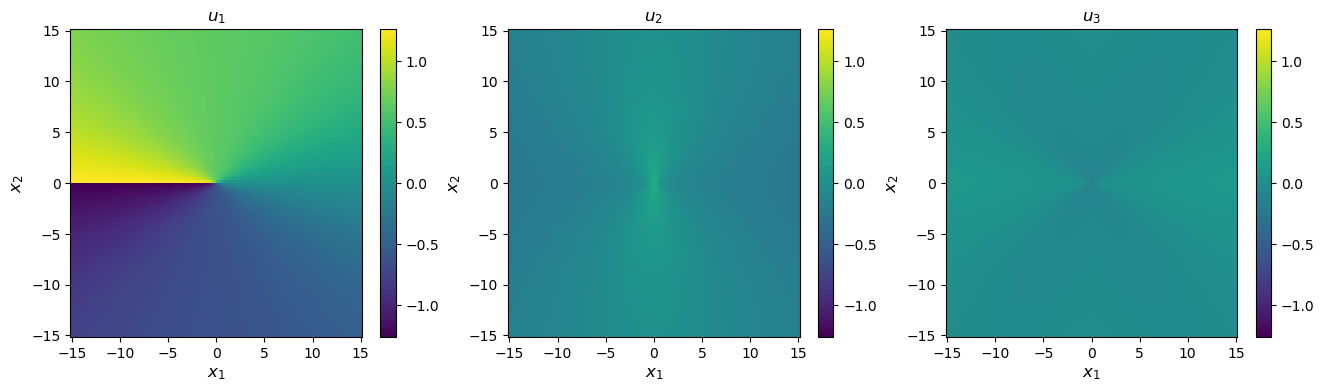

In [10]:
# Compute displacements
disp = solution.displacement(coords)

# Plot
disp_max = np.abs(disp.max())
fig, axes = plt.subplots(figsize=(16,4), ncols=3)

for i in range(3):
    im = axes[i].pcolormesh(xvals, yvals, disp[:,i].reshape(num_xy, num_xy), vmin=-disp_max, vmax=disp_max)
    axes[i].set_title(f'$u_{{{i+1}}}$')
    axes[i].set_xlabel(xlabel, fontsize='large')
    axes[i].set_ylabel(ylabel, fontsize='large')
    fig.colorbar(im, ax=axes[i])

print('Coordinates and displacements in Angstroms')
plt.show()

Stress

Stress components in GPa, coordinates in Angstroms


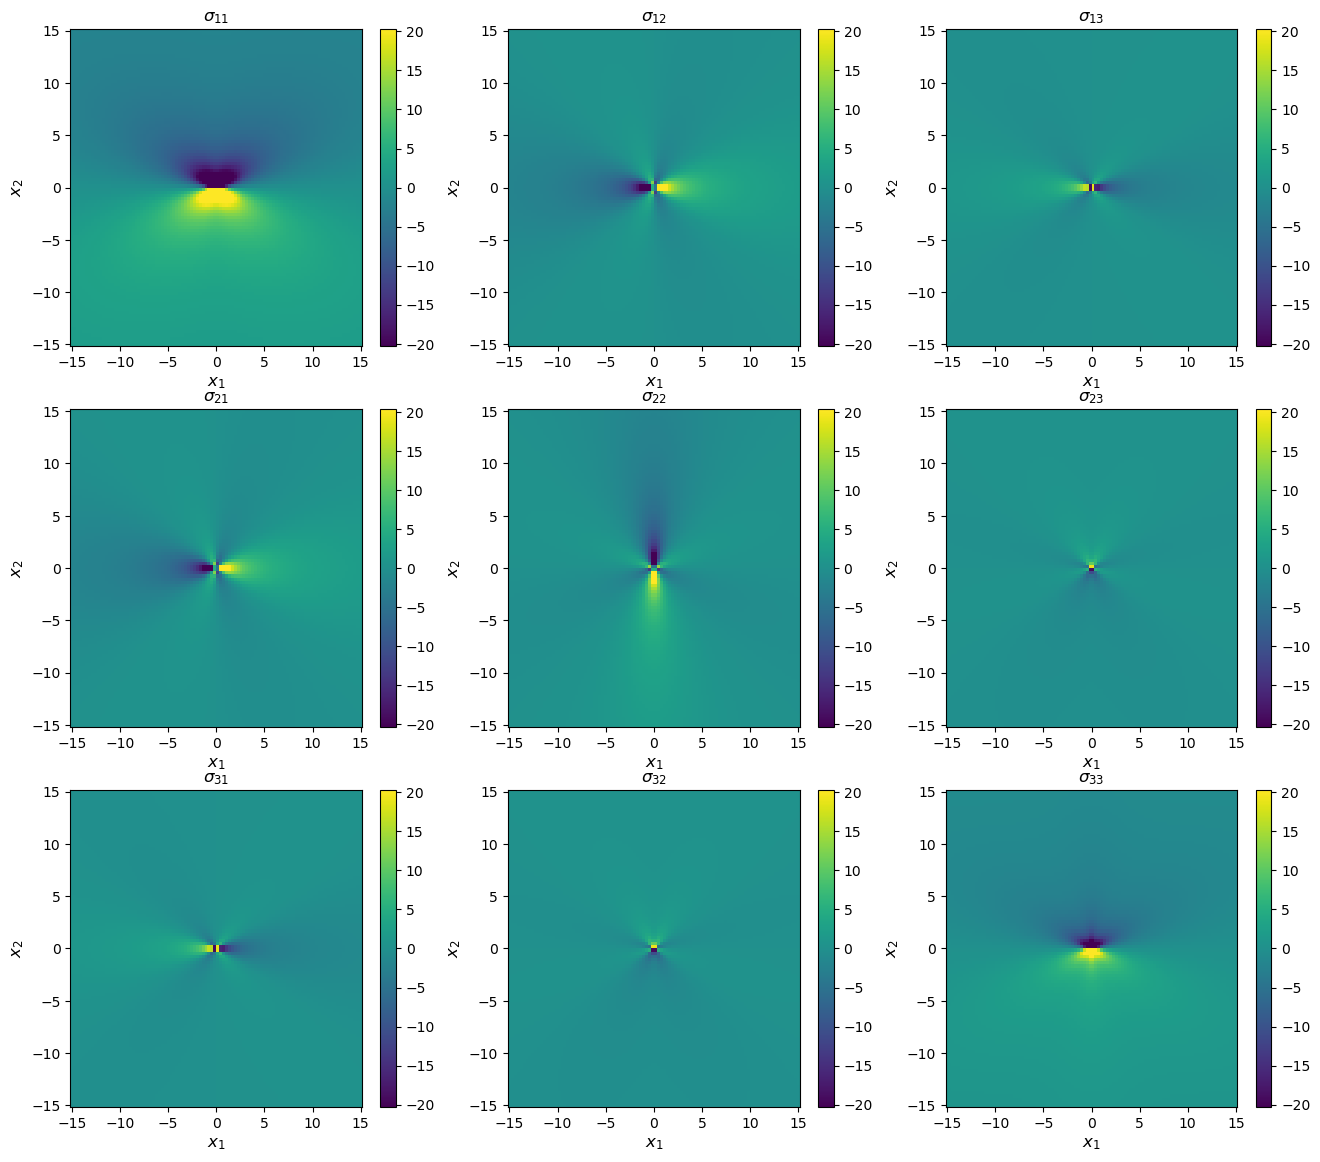

In [11]:
# Compute stress states
stress = uc.get_in_units(solution.stress(coords), 'GPa')

# Plot
stress_max = np.abs(stress.max()) / 10
fig, axes = plt.subplots(figsize=(16,14), ncols=3, nrows=3)

for i in range(3):
    for j in range(3):
        im = axes[i, j].pcolormesh(xvals, yvals, stress[:, i, j].reshape(num_xy, num_xy), vmin=-stress_max, vmax=stress_max)
        axes[i, j].set_title(f'$\sigma_{{{i+1}{j+1}}}$')
        axes[i, j].set_xlabel(xlabel, fontsize='large')
        axes[i, j].set_ylabel(ylabel, fontsize='large')
        fig.colorbar(im, ax=axes[i, j])

print('Stress components in GPa, coordinates in Angstroms')
plt.show()

Strain

Strain components, coordinates in Angstroms


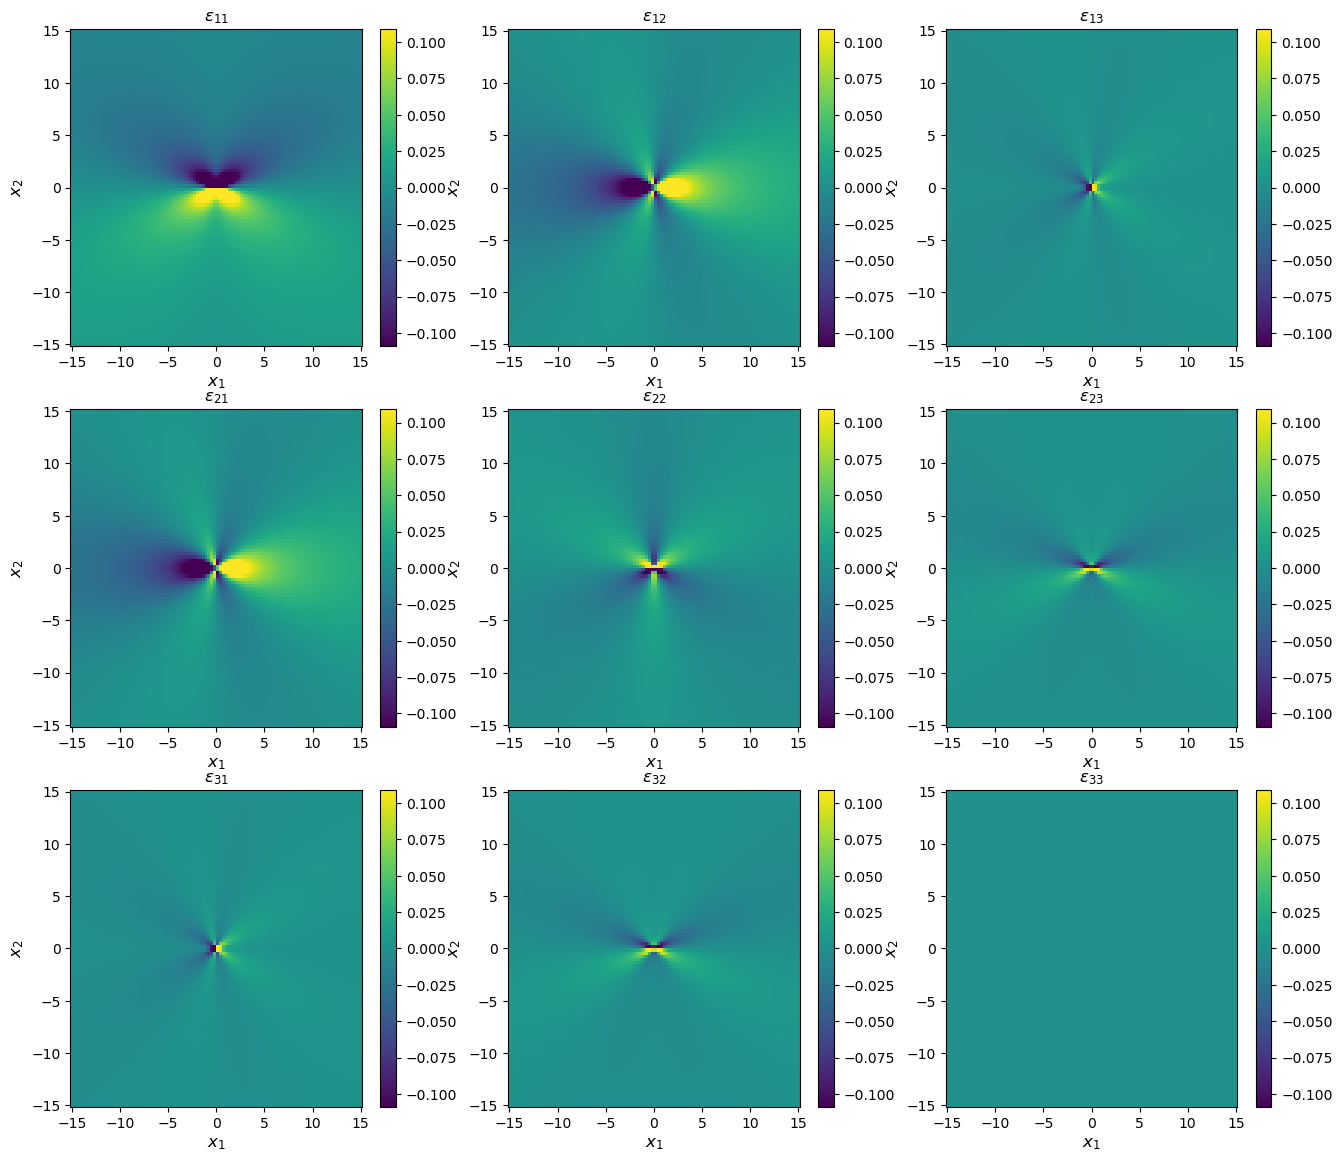

In [12]:
# Compute stress states
strain = solution.strain(coords)

# Plot
strain_max = np.abs(strain.max()) / 10
fig, axes = plt.subplots(figsize=(16,14), ncols=3, nrows=3)

for i in range(3):
    for j in range(3):
        im = axes[i, j].pcolormesh(xvals, yvals, strain[:, i, j].reshape(num_xy, num_xy), vmin=-strain_max, vmax=strain_max)
        axes[i, j].set_title(f'$\epsilon_{{{i+1}{j+1}}}$')
        axes[i, j].set_xlabel(xlabel, fontsize='large')
        axes[i, j].set_ylabel(ylabel, fontsize='large')
        fig.colorbar(im, ax=axes[i, j])

print('Strain components, coordinates in Angstroms')
plt.show()

## 4. Direct check of strain energy

For fun, you can check the nature of the solution by directly computing the dislocation solution's strain energy and comparing it to the solution's strain energy coefficients.

$$ \frac{W}{l} = \frac{K b^2}{4 \pi} \ln{ \left( \frac{R}{r_0} \right)} = \frac{1}{2} \int_{r_0}^{R} \sigma_{ij} \epsilon_{ij} dr$$



In [13]:
def self_energy_eval(dislsol, outer_r, inner_r=None, gridnum=1000):
    """
    Numerically evaluates the elastic strain energy of a Volterra dislocation
    within a cylindrical ring centered around the dislocation line.
    
    The strain energy is computed by integrating 1/2 σ_ij ϵ_ij dr over a cylindrical
    ring region with inner and outer radii. Here, the stress and strain fields are
    obtained from the dislocation solution at grid points within the ring, and the
    integral is numerically evaluated.
    
    Parameters
    ----------
    dislsol : atomman.defect.VolterraDislocation
        A Volterra dislocation solution.
    outer_r : float
        The outer radius of the cylindrical ring to use.
    inner_r : float, optional
        The inner radius of the cylindrical ring to use, i.e. the dislocation core
        radius.  If not given, will be taken as 5 * |b|.
    gridnum : int, optional
        The calculation uses a square grid of size gridnum*gridnum to evaluate the
        strain energy density as a function of position.  The numerical integral for
        the strain energy then uses the corresponding values with grid points inside
        the ring region.  Increasing gridnum increases the computational cost as well
        as improves the numerical integral.  Default value is 1000.
        
    Returns
    -------
    E_strain : float
        The computed elastic strain energy within the cylindrical ring.    
    """
    if inner_r is None:
        inner_r = 5 * np.linalg.norm(dislsol.burgers)
    
    assert outer_r > inner_r, 'outer_r must be greater than inner_r'
    
    # Build square coordinate grid
    xy_vals = np.linspace(-outer_r, outer_r, gridnum)
    delta_xy = xy_vals[1] - xy_vals[0]
    xvals, yvals = np.meshgrid(xy_vals, xy_vals)
    coords = np.outer(xvals, dislsol.m) + np.outer(yvals, dislsol.n)
    r2 = (xvals**2 + yvals**2).flatten()

    # Compute elastic strain energy density at the coords
    ϵ_ij = dislsol.strain(coords)
    σ_ij = dislsol.stress(coords)
    E_density = 1/2 * np.einsum('...ij, ...ij ->...', σ_ij, ϵ_ij)

    # Remove values where coordinates are not in the ring
    E_density[r2 < inner_r**2] = np.nan
    E_density[r2 > outer_r**2] = np.nan

    # Sum energy density and compute the ln term.
    E_strain = np.nansum(E_density * delta_xy * delta_xy)
        
    return E_strain

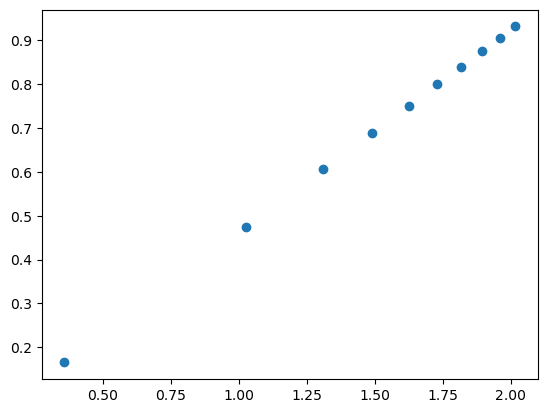

Solution K: 74.09648693884493
Evaluated K: 74.10133673627267


In [14]:
bmag = np.linalg.norm(solution.burgers)
max_outer_r = 250 * bmag
inner_r = 5 * bmag
num_r = 10

E_strains = []
ln_terms = []

for outer_r in np.linspace(2*inner_r, max_outer_r, num_r):
    
    # Numerically compute the strain energy between inner_r, outer_r
    E_strain = self_energy_eval(solution, outer_r=outer_r, inner_r=inner_r)
    E_strains.append(E_strain)
    
    # Compute the ln term: b^2 / (4 pi) * ln(outer_r/inner_r)
    ln_term = solution.burgers.dot(solution.burgers) * np.log(outer_r / inner_r) / (4 * np.pi)
    ln_terms.append(ln_term)

# Plot strain energies vs. the ln terms
plt.plot(ln_terms, E_strains, 'o')
plt.show()

# Evaluate K_coeff as the slope of the plot
r = linregress(ln_terms, E_strains)
K_coeff = r.slope

# Print values
print('Solution K:', uc.get_in_units(solution.K_coeff, 'GPa'))
print('Evaluated K:', uc.get_in_units(K_coeff, 'GPa'))